# Étape 1 — Exploration & Non-Supervisé (PTB-XL via WFDB)

Le notebook est une version pour l'étape 1 (EDA + clustering) utilisant un dataset différent.

Il cible **PTB-XL** au format WFDB (`.hea` + `.dat`) dans un dossier `records100` ou `records500`.

Objectifs :
1) Charger un sous-ensemble de records WFDB (12 dérivations, 10s)  
2) EDA rapide (tracés)  
3) Extraction de features (stats par dérivation + features simples)  
4) StandardScaler + PCA (viz)  
5) Clustering KMeans + DBSCAN + métriques (silhouette, etc.)



In [19]:

from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# wfdb (PTB-XL est en format WFDB)
try:
    import wfdb
except ImportError as e:
    raise ImportError(
        "wfdb n'est pas installé. Installer dans ton environnement :"
        "pip install wfdb"
        "Puis relancer le notebook."
    ) from e


## 1) Chemin vers PTB-XL

Permet de trouver les datasets :
- `.../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100`
- `.../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500`


In [20]:
# Racine réelle = parent du dossier Projet
PROJECT_ROOT = Path.cwd().parent

DATA_DIR = PROJECT_ROOT / "Dataset Projet"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("Existe ?", DATA_DIR.exists())

print("exists:", DATA_DIR.exists())
print("is_dir:", DATA_DIR.is_dir())

hea_files = sorted(DATA_DIR.rglob("*.hea"))
print("nb records (.hea):", len(hea_files))

# aperçu extensions
exts = Counter(p.suffix.lower() for p in DATA_DIR.rglob("*") if p.is_file())
print("extensions:", dict(exts))
BASE_DIR = DATA_DIR


PROJECT_ROOT: /Users/raphc/Documents/Cours M2/algorithmique supervisé
DATA_DIR: /Users/raphc/Documents/Cours M2/algorithmique supervisé/Dataset Projet
Existe ? True
exists: True
is_dir: True
nb records (.hea): 21837
extensions: {'.csv': 555, '': 3, '.py': 1, '.txt': 2, '.hea': 21837, '.dat': 21837}


## 2) Charger un sous-ensemble de records WFDB

On charge `N` records pour commencer (sinon ça peut être long).  
Chaque record = matrice `(n_samples, n_leads)` (souvent 12 leads).


In [21]:
def load_ptbxl_subset(base_dir: Path, n_records: int = 50, seed: int = 42):
    hea_files = sorted(base_dir.rglob("*.hea"))
    if len(hea_files) == 0:
        raise FileNotFoundError("Aucun .hea trouvé. Vérifie BASE_DIR.")

    rng = np.random.default_rng(seed)
    pick = rng.choice(len(hea_files), size=min(n_records, len(hea_files)), replace=False)
    pick = sorted(pick)

    signals = []
    record_ids = []
    fs_list = []

    for idx in pick:
        hea = hea_files[idx]
        rec_path = hea.with_suffix("")  # path sans extension
        sig, fields = wfdb.rdsamp(str(rec_path))  # sig: (n_samples, n_channels)
        signals.append(sig.astype(np.float32))
        record_ids.append(hea.stem)
        fs_list.append(fields.get("fs", None))

    X = np.stack(signals, axis=0)  # (N, n_samples, n_leads)
    return X, record_ids, fs_list

N_RECORDS = 80
X, record_ids, fs_list = load_ptbxl_subset(BASE_DIR, n_records=N_RECORDS, seed=42)

print("X shape:", X.shape)  # (N, T, C)
print("fs (unique):", sorted(set([f for f in fs_list if f is not None])))


X shape: (80, 1000, 12)
fs (unique): [100]


## 3) EDA — Visualiser quelques records

On trace 1 ou 2 dérivations pour quelques patients/records.


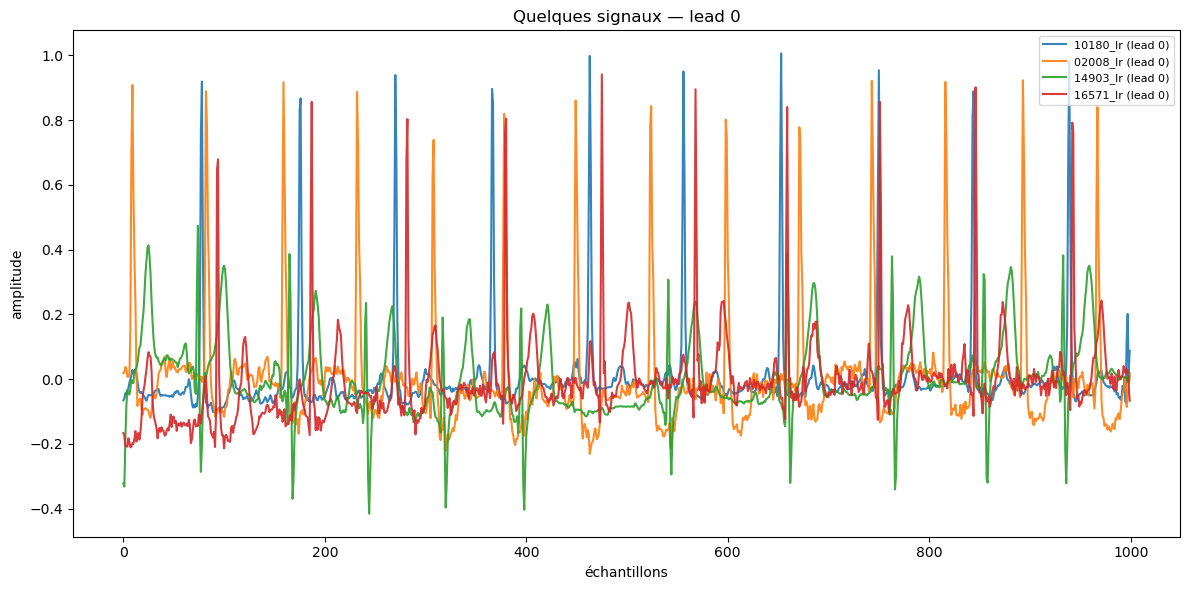

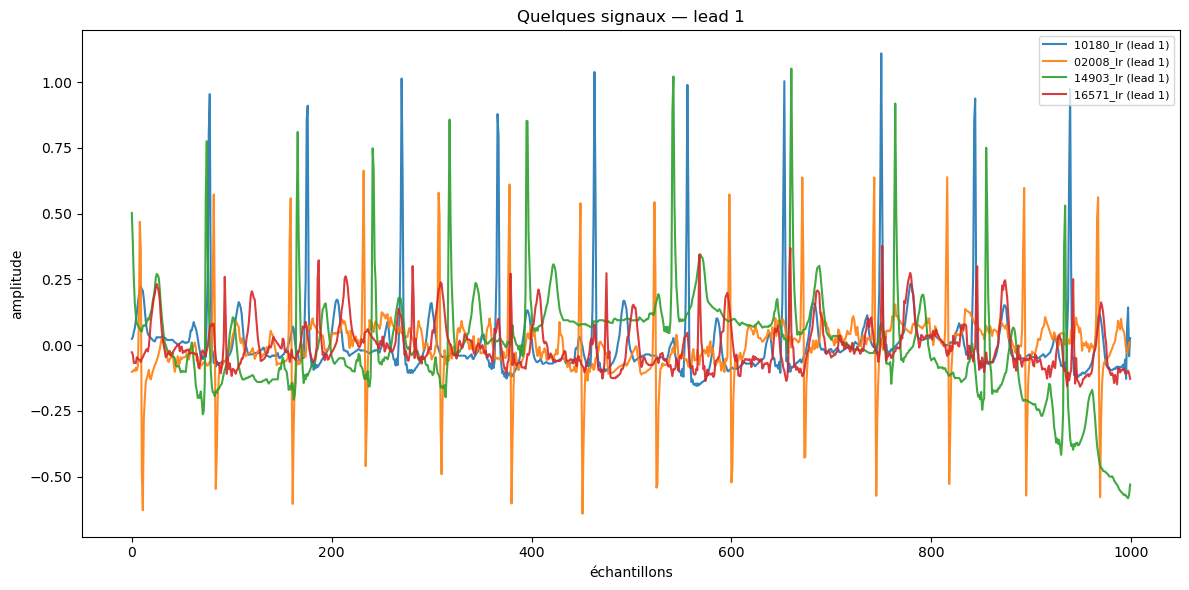

In [22]:
def plot_records(X, record_ids, lead_idx=0, n_show=4, seed=42):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(X.shape[0], size=min(n_show, X.shape[0]), replace=False)

    plt.figure(figsize=(12, 6))
    for j in idxs:
        plt.plot(X[j, :, lead_idx], label=f"{record_ids[j]} (lead {lead_idx})", alpha=0.9)
    plt.title(f"Quelques signaux — lead {lead_idx}")
    plt.xlabel("échantillons")
    plt.ylabel("amplitude")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

plot_records(X, record_ids, lead_idx=0, n_show=4)
plot_records(X, record_ids, lead_idx=1, n_show=4)


## 4) Extraction de features (stats par lead)

Pour chaque record :
- features simples par dérivation : mean, std, min, max, ptp, énergie, abs(dx) mean  
On concatène les features de chaque dérivation => un vecteur par record.


In [23]:
def features_one_record(sig_2d: np.ndarray) -> np.ndarray:
    # sig_2d: (T, C)
    sig = np.asarray(sig_2d, dtype=np.float32)
    T, C = sig.shape

    feats = []
    for c in range(C):
        x = sig[:, c]
        dx = np.diff(x)
        feats.extend([
            float(x.mean()),
            float(x.std()),
            float(x.min()),
            float(x.max()),
            float(x.max() - x.min()),
            float(np.mean(x**2)),
            float(np.mean(np.abs(dx))) if len(dx) else 0.0,
            float(np.std(dx)) if len(dx) else 0.0,
        ])
    return np.array(feats, dtype=np.float32)

def build_feature_matrix(X_3d: np.ndarray) -> np.ndarray:
    return np.stack([features_one_record(X_3d[i]) for i in range(X_3d.shape[0])], axis=0)

F = build_feature_matrix(X)  # (N, n_features)
print("Feature matrix shape:", F.shape)

# DataFrame (facilite EDA)
n_leads = X.shape[2]
feat_names = []
base = ["mean","std","min","max","ptp","energy","abs_dx_mean","dx_std"]
for lead in range(n_leads):
    for b in base:
        feat_names.append(f"lead{lead}_{b}")

F_df = pd.DataFrame(F, columns=feat_names)
F_df.head()


Feature matrix shape: (80, 96)


,lead0_mean,lead0_std,lead0_min,lead0_max,lead0_ptp,lead0_energy,lead0_abs_dx_mean,lead0_dx_std,lead1_mean,lead1_std,...,lead10_abs_dx_mean,lead10_dx_std,lead11_mean,lead11_std,lead11_min,lead11_max,lead11_ptp,lead11_energy,lead11_abs_dx_mean,lead11_dx_std
0,-0.000771,0.085243,-0.156,0.520,0.676,0.007267,0.019491,0.055206,-0.001221,0.080020,...,0.026521,0.090101,-0.001296,0.111102,-0.389,0.687,1.076,0.012345,0.022251,0.072931
1,-0.000970,0.172122,-0.369,0.762,1.131,0.029627,0.030693,0.068087,0.002150,0.149452,...,0.049598,0.150813,-0.005446,0.168742,-0.916,0.599,1.515,0.028503,0.036909,0.112105
2,-0.001759,0.074794,-0.166,0.425,0.591,0.005597,0.026017,0.050899,-0.004305,0.107523,...,0.040388,0.115734,-0.003477,0.125842,-0.131,0.766,0.897,0.015848,0.029183,0.082385
3,0.005259,0.201803,-0.415,0.742,1.157,0.040752,0.026779,0.043311,0.004144,0.207903,...,0.031444,0.064786,-0.002748,0.218213,-0.427,0.868,1.295,0.047625,0.025031,0.054049
4,-0.003303,0.170074,-0.382,0.874,1.256,0.028936,0.026586,0.071895,-0.003511,0.195669,...,0.035258,0.119180,0.003801,0.152895,-0.133,1.055,1.188,0.023391,0.029698,0.099022


## 5) EDA des features : distributions + corrélations (optionnel)

Tu peux inspecter quelques histogrammes et une corrélation rapide.


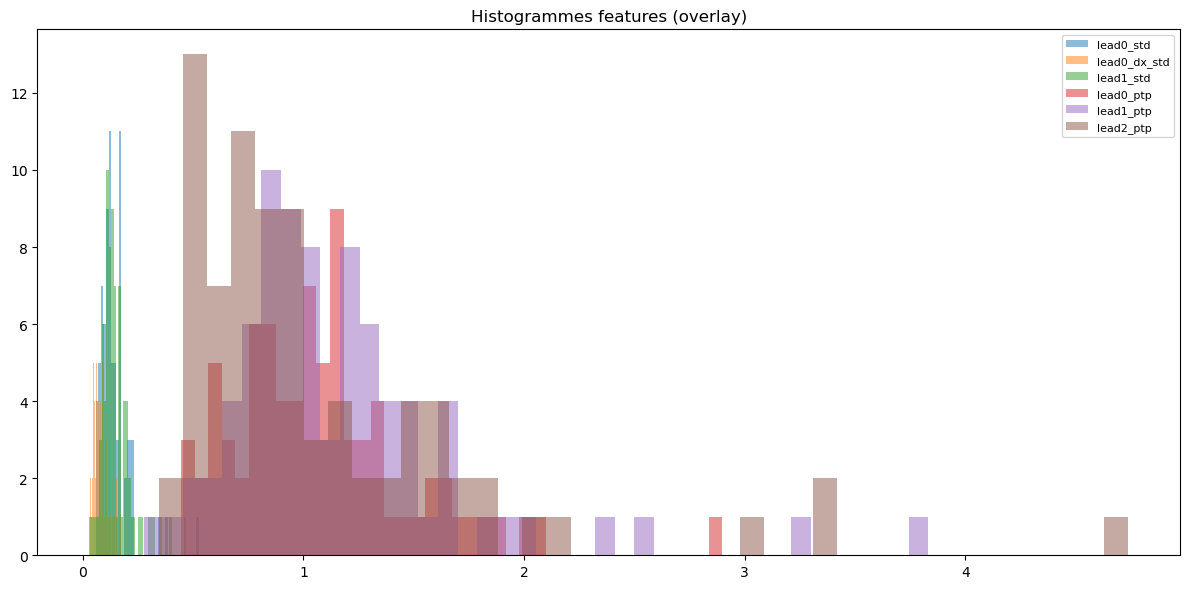

In [24]:
def plot_feature_hists(F_df: pd.DataFrame, cols, bins=40):
    plt.figure(figsize=(12, 6))
    for c in cols:
        plt.hist(F_df[c].values, bins=bins, alpha=0.5, label=c)
    plt.title("Histogrammes features (overlay)")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

sample_cols = [c for c in F_df.columns if c.endswith("_std")][:3] + [c for c in F_df.columns if c.endswith("_ptp")][:3]
plot_feature_hists(F_df, sample_cols)


## 6) StandardScaler + PCA 2D (visualisation)

On standardise les features puis PCA pour visualiser.


In [25]:
scaler = StandardScaler()
F_scaled = scaler.fit_transform(F_df.values)

pca2 = PCA(n_components=2, random_state=42)
Z2 = pca2.fit_transform(F_scaled)

print("Variance ratio:", pca2.explained_variance_ratio_)


Variance ratio: [0.33179495 0.11119707]


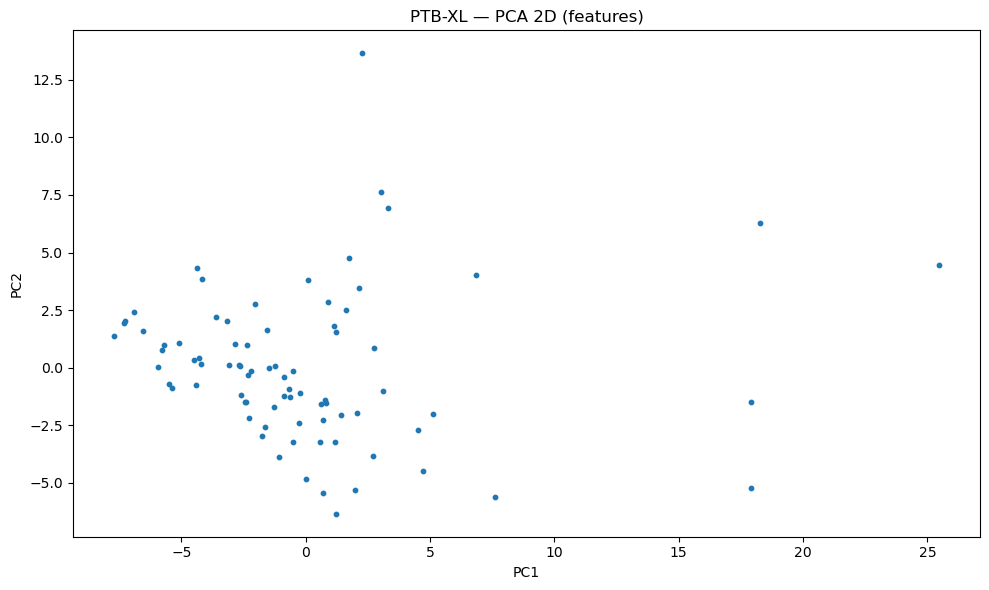

In [26]:

def scatter_pca(Z, c=None, title="PCA 2D"):
    plt.figure(figsize=(10, 6))
    if c is None:
        plt.scatter(Z[:, 0], Z[:, 1], s=10)
    else:
        plt.scatter(Z[:, 0], Z[:, 1], s=10, c=c)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

scatter_pca(Z2, title="PTB-XL — PCA 2D (features)")


## 7) Clustering KMeans : recherche de k + métriques

On teste plusieurs k et on retient le meilleur selon silhouette (sur l'espace des features standardisées).


In [27]:

def kmeans_grid(F_scaled, k_list=range(2, 11), random_state=42):
    rows = []
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=20, max_iter=500)
        lab = km.fit_predict(F_scaled)

        sil = silhouette_score(F_scaled, lab)
        dbi = davies_bouldin_score(F_scaled, lab)
        ch  = calinski_harabasz_score(F_scaled, lab)

        rows.append({"k": k, "silhouette": sil, "davies_bouldin": dbi, "calinski_harabasz": ch})
    return pd.DataFrame(rows).sort_values("silhouette", ascending=False)

k_grid = kmeans_grid(F_scaled, range(2, 11))
k_grid


,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.547192,0.953316,23.346883
1,3,0.157944,1.977962,18.350722
2,4,0.145818,1.795724,16.239425
4,6,0.115848,1.584913,13.461510
3,5,0.112803,1.831317,14.653642
5,7,0.111972,1.420547,12.808500
8,10,0.109669,1.161839,11.172357
6,8,0.106987,1.285419,12.087902
7,9,0.105700,1.471213,11.516470


best_k: 2
silhouette: 0.5471922159194946


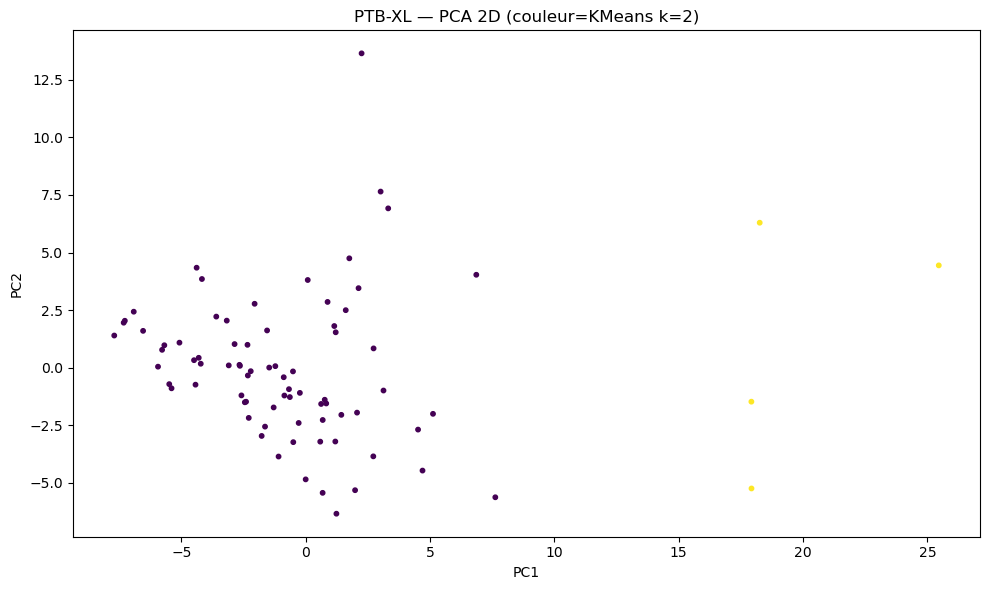

In [28]:

best_k = int(k_grid.iloc[0]["k"])
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20, max_iter=500)
labels_km = kmeans.fit_predict(F_scaled)

print("best_k:", best_k)
print("silhouette:", float(silhouette_score(F_scaled, labels_km)))

scatter_pca(Z2, c=labels_km, title=f"PTB-XL — PCA 2D (couleur=KMeans k={best_k})")


## 8) Clustering DBSCAN (optionnel)

DBSCAN découvre automatiquement le nombre de clusters, et peut mettre du bruit (`-1`).  
On teste quelques couples (`eps`, `min_samples`) et on regarde :
- nb clusters
- % bruit
- silhouette sur points non-bruit (si >=2 clusters)


In [29]:
def run_dbscan(F_scaled, eps=1.0, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    lab = db.fit_predict(F_scaled)

    n_clusters = len(set(lab)) - (1 if -1 in lab else 0)
    noise_pct = float(np.mean(lab == -1))

    sil_non_noise = None
    mask = lab != -1
    if mask.sum() > 1 and len(set(lab[mask])) > 1:
        sil_non_noise = float(silhouette_score(F_scaled[mask], lab[mask]))

    metrics = {
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": int(n_clusters),
        "noise_pct": noise_pct,
        "silhouette_non_noise": sil_non_noise,
    }
    return lab, metrics

tests = []
for eps in [0.5, 0.8, 1.0, 1.2, 1.5]:
    for ms in [5, 10, 20]:
        _, m = run_dbscan(F_scaled, eps=eps, min_samples=ms)
        tests.append(m)

db_grid = pd.DataFrame(tests).sort_values(
    ["silhouette_non_noise", "n_clusters", "noise_pct"],
    ascending=[False, False, True],
    na_position="last"
)
db_grid.head(10)


,eps,min_samples,n_clusters,noise_pct,silhouette_non_noise
0,0.5,5,0,1.0,None
1,0.5,10,0,1.0,None
2,0.5,20,0,1.0,None
3,0.8,5,0,1.0,None
4,0.8,10,0,1.0,None
5,0.8,20,0,1.0,None
6,1.0,5,0,1.0,None
7,1.0,10,0,1.0,None
8,1.0,20,0,1.0,None
9,1.2,5,0,1.0,None


In [30]:
best = db_grid.dropna(subset=["silhouette_non_noise"]).head(1)
if len(best) == 0:
    print("DBSCAN : aucun paramétrage n'a produit >=2 clusters sans bruit. Essaye d'autres eps/min_samples.")
else:
    eps = float(best.iloc[0]["eps"])
    ms  = int(best.iloc[0]["min_samples"])
    labels_db, metrics_db = run_dbscan(F_scaled, eps=eps, min_samples=ms)
    print("Best DBSCAN:", metrics_db)
    scatter_pca(Z2, c=labels_db, title=f"PTB-XL — PCA 2D (couleur=DBSCAN eps={eps}, min_samples={ms})")


DBSCAN : aucun paramétrage n'a produit >=2 clusters sans bruit. Essaye d'autres eps/min_samples.


## 9) Résumé (pour ton rapport)

- Dataset : PTB-XL (WFDB) — `records100` ou `records500`  
- Subset : N records  
- Features : stats + dérivées simples par lead  
- StandardScaler + PCA 2D  
- KMeans : meilleur k et silhouette  
- DBSCAN : (eps, min_samples), % bruit, silhouette sans bruit (si possible)
